![image](https://fontmeme.com/permalink/210428/7464690d81ebde4bf9006cfe4deedb23.png)
# Charting the social graphs of fantasy characters in A Song Of Ice And Fire
https://sorenmulli.github.io/graph-of-thrones
#### Søren Winkel Holm, Anders Henriksen, Oskar Wiese

In [2]:
""" Python initialization """
from __future__ import annotations
import re
import os
import json
from collections import defaultdict
import itertools
import math
import datetime

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import networkx as nx
import pandas as pd

from psaw import PushshiftAPI
from tqdm import tqdm


mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300
DATAPATH = "data" # For data we keep on git
LOCAL_DATAPATH = "local_data" # For data that is copyrighted (the books) or too big to be on git

## 1. Motivation: Understanding fantasy world fandoms

/r/asoiaf, the main discussion subreddit for A Song of Ice and Fire has 700K subscribers and many in-depth posts every day with beginnings such as 
> "While reading (again and again) the series, I found this and i wanted to share it with you so you could tell me what you think ...",

or 

>"It's pretty clear Stannis isn't an endgame character, so I don't see Stannis being the 1000th Lord Commander of the Night's Watch as a possibility. Now I am just making fun speculation but I think ..."

Our goal is to gain and convey insight into the relationship between the fantasy world and its' exploreres, and for this, the above subreddit was chosen as the community to examine, making the datasets both (1) a number of discussion posts from /r/asoiaf and (2) the text of the book series.

## 2. Handling Data: Two different worlds of text

As mentioned above, we gather text from both the original works and reddit discusions.

From this, we create two graphs of character relationships in the two corpora.

The data fetching and processing is shown in code below, where the choices are also discussed.

### 2.1 The book texts

The five books in the series "A Song of Ice and Fire" (ISBN: 978-0-345-53553-5) were acquired as e-books in the EPUB format.

They were converted to plain text and the below, simple preprocessing was performed, dividing them into chapters bassed on matching text pattern.

In [23]:
BOOK_FILES = [
    "book1.txt",
    "book2.txt",
    "book3.txt",
    "book4.txt",
    "book5.txt",
]
def read_books(path: str) -> list[str]:
    docs = list()
    for b in BOOK_FILES:
        with open(os.path.join(path, b), "r") as f:
            docs.append(
                f.read()
            )
    return docs

def build_df_book(books: list[str]) -> pd.DataFrame:
    chapters = list()
    chap_num = -1
    for i, book in enumerate(books):
        lines = list(book.splitlines())
        for j, line in enumerate(lines):
            # Chapter criterion: Upper case and followed by empty line
            if line and line.isupper() and not lines[j+1]:
                chap_num += 1
                chapters.append({
                    "book": i,
                    "title": line.strip(),
                    "lines": [line]
                })
                # Set up previous chapter
                if (old_num := chap_num - 1) >= 0:
                    chapters[old_num]["text"] = "\n".join(chapters[old_num]["lines"])
                    chapters[old_num].pop("lines")
            else:
                chapters[chap_num]["lines"].append(line)
    # Clean up last chapter
    chapters[-1]["text"] = "\n".join(chapters[-1]["lines"])
    chapters[-1].pop("lines")
    return pd.DataFrame(chapters)

In [32]:
books = read_books(LOCAL_DATAPATH)
print(f"Length of text strings of the five raw books in chars: {', '.join(str(len(b)) for b in books)}")

Length of text strings of the five raw books in chars: 1589207, 1732787, 2244618, 1597714, 2255779


In [34]:
df_book = build_df_book(books)
df_book

,book,title,text
0,0,PROLOGUE,"PROLOGUE\n\n\n\n“We should start back,” Gared ..."
1,0,BRAN,BRAN\n\n\n\n\n\nThe morning had dawned clear a...
2,0,CATELYN,CATELYN\n\n\n\n\n\nCatelyn had never liked thi...
3,0,DAENERYS,DAENERYS\n\n\n\n\n\nHer brother held the gown ...
4,0,EDDARD,EDDARD\n\n\n\n\n\nThe visitors poured through ...
...,...,...,...
353,4,THE DRAGONTAMER,THE DRAGONTAMER\n\n\n\n\nThe night crept past ...
354,4,JON,"JON\n\n\n\n\nLet them die,” said Queen Selyse...."
355,4,THE QUEEN’S HAND,THE QUEEN’S HAND\n\n\n\n\nThe Dornish prince w...
356,4,DAENERYS,DAENERYS\n\n\n\n\nThe hill was a stony island ...


In [10]:
print(f"""
Number of chapters:   {len(df_book)}
Number of words:      {sum(len(c.split()) for c in df_book.text)}
Number of letters:    {sum(len(c) for c in df_book.text)}
Average chapter len.: {np.mean([len(c.split()) for c in df_book.text]):.1f}
""")


Number of chapters:   358
Number of words:      1741449
Number of letters:    9419747
Average chapter len.: 4864.4



We have a large text corpus measured in words (17M), but as the chapters are quite long, we end up with only 358 easily-discernable documents.


### 2.2 The reddit texts

Posts from the subreddit /r/asoiaf (A Song of Ice and Fire) were fetched in a period of multiple years.

The time period was chosen to comply with practical time limits on our part and excluded discussions made after the release of the final season of the TV show as we imagined these might concern themselves more with the quality of the TV show than character discussion.

Only posts with non-empty selftext were saved.

In [ ]:
api = PushshiftAPI()
features = ["title", "id", "score", "author", "created_utc", "selftext"]
subreddit = "asoiaf"
date1 = int(datetime.datetime(2015,7,16).timestamp())
date2 = int(datetime.datetime(2019,4,14).timestamp())
gen = api.search_submissions(subreddit = subreddit, after = date1, before = date2, q='', filter = features, limit = 3 * 10**5)

In [ ]:
# Perform the actual download
results = list(gen)

In [ ]:
ids, title, score, author, created_utc, selftext = [], [], [], [], [], []
for i in range(len(results)):
    try:
        selftext.append(results[i].d_['selftext'])
        title.append(results[i].d_['title'])
        score.append(results[i].d_['score'])
        created_utc.append(results[i].d_['created_utc'])
        author.append(results[i].d_['author'])
    except KeyError:
        pass
        

df_reddit = pd.DataFrame(
{
    "title" : title,
    "score" : score,
    "created" : created_utc,
    "author" : author,
    "selftext" : selftext
}, index = None)

In [12]:
df_reddit = df_reddit[df_reddit['selftext'] != '']
df_reddit = df_reddit[df_reddit['selftext'] != '[removed]']
df_reddit = df_reddit.dropna()
df_reddit

,title,score,created,author,selftext
3,(Spoilers extended) This sub is going to explo...,7,1555189915,seperationsunday,2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...
7,[SPOILERS EXTENDED] Miiri’s Prophecy,2,1555187335,ChayaFeige,Miiri Maaz Dur Prophecy decoded using Gilly’s ...
8,(Spoilers Main) GOT Theory: You Can't Trust th...,47,1555186553,John-on-gliding,The events that led to the creation of the Whi...
10,(Spoilers extended)The Night King needs Bran,3,1555184407,dikziw,Ever since the episode where Bran is “marked” ...
16,(Spoilers Extended) Ending theory: a Tudor Wes...,101,1555182090,5555512369874,ASOIAF has a number of historical inspirations...
...,...,...,...,...,...
117736,(Spoilers All) Tv Show direction,17,1437000037,ShutYoFaceGrandma,"So, I was very unhappy about the Sansa switche..."
117737,(Spoilers All) Need help finding Stannis quote...,1,1436999414,user1444,Can you guys list every scene you can think of...
117738,(Spoilers All) I didn't realize how much fores...,62,1436999159,Compeau,This is from a Bran chapter in AGOT.\r\n\r\n&g...
117740,(Spoilers All) AGOT Sansa chapter with the for...,0,1436998367,itsmearyastark,"I don't know if this has been mentioned here, ..."


In [8]:
print(f"""
Number of posts:     {len(df_reddit)}
Number of words:     {sum(len(p.split()) for p in df_reddit.selftext)}
Number of letters:   {sum(len(p) for p in df_reddit.selftext)}
Average post length: {np.mean([len(p.split()) for p in df_reddit.selftext]):.1f}
""")


Number of posts:     72090
Number of words:     15297004
Number of letters:   88291619
Average post length: 212.2



The reddit selftext corpus is about twice as large as the book corpus measured in words, but it contains a much higher number of different, and thus smaller, documents (72K).

Superficial inspection of the text in the reddit posts show the number of documents is, naturally, not the only difference between the prose of George R. R. Martin and the forum discussions.

### 2.3 Building graphs of both

We manually create a list of named characters from the fantasy universe, also saving one-word nick names where we take care not to introduce false positives (e.g. we don't allow Jon Snow to have the nickname "Snow" as this is also the name of Ramsey Snow).

In [92]:
def get_names(path: str = "data") -> dict[str, list[str]]:
    """
    Reads the character data base characters.json.
    """
    with open(os.path.join(path, "characters.json"), "r") as f:
        characters = json.load(f)
    return characters
characters = get_names()
print(f"Fetched {len(characters)} characters, here are some:\n - " + "\n - ".join([f"{v}: \t\t{k}" for v, k in characters.items()][:5]))

Fetched 34 characters, here are some:
 - Eddard 'Ned' Stark: 		['Ned', 'Eddard']
 - Robert Baratheon: 		['Robert']
 - Jaime Lannister: 		['Jaime']
 - Catelyn Stark: 		['Catelyn', 'Cat', 'Stoneheart']
 - Cersei Lannister: 		['Cersei']


The nickname pattern is searched through the alphabetically filtered tokens in the lower-cased text and exact matched are saved.

No lemmatization and stemming is done, as we are working with proper nouns and adding this seemed to give too many false positives.

In [44]:
def find_names(doc: str, name_db: dict[str, list[str]]) -> list[str]:
    """
    Returns a list of all characters that were matched in document.
    Characters are returned as full names; not as they were found.
    """
    out = set()
    for w in doc.lower().split():
        w = re.sub(r"[^a-z]", "", w) # Remove all non-alphabetical
        for name, keys in name_db.items():
            if any(k.lower() == w for k in keys):
                out.add(name)
                break
    return list(out)

def mentioned_chars(df: pd.DataFrame, text_col="text") -> pd.DataFrame:
    """
    Adds a new "names" column in pd dataframes which contains all characters that were mentioned in this text.
    """
    tqdm.pandas()
    row_name_finder = lambda row: find_names(row[text_col], names)
    df["names"] = df.apply(row_name_finder, axis=1)
    return df

This search for matches is performed though both the book and the reddit corpoa

In [50]:
df_book = mentioned_chars(df_book)
df_book

,book,title,text,names
0,0,PROLOGUE,"PROLOGUE\n\n\n\n“We should start back,” Gared ...","['Jon Snow', 'Robert Baratheon']"
1,0,BRAN,BRAN\n\n\n\n\n\nThe morning had dawned clear a...,"['Jon Snow', ""Eddard 'Ned' Stark"", 'Robert Bar..."
2,0,CATELYN,CATELYN\n\n\n\n\n\nCatelyn had never liked thi...,"[""Eddard 'Ned' Stark"", 'Jon Snow', 'Robert Bar..."
3,0,DAENERYS,DAENERYS\n\n\n\n\n\nHer brother held the gown ...,"['Jorah Mormont', 'Viserys Targaryen', 'Daener..."
4,0,EDDARD,EDDARD\n\n\n\n\n\nThe visitors poured through ...,"['Robert Baratheon', ""Eddard 'Ned' Stark"", 'Jo..."
...,...,...,...,...
353,4,THE DRAGONTAMER,THE DRAGONTAMER\n\n\n\n\nThe night crept past ...,['Daenerys Targaryen']
354,4,JON,"JON\n\n\n\n\nLet them die,” said Queen Selyse....","['Jon Snow', 'Samwell Tarly', 'Robb Stark', 'S..."
355,4,THE QUEEN’S HAND,THE QUEEN’S HAND\n\n\n\n\nThe Dornish prince w...,"['Daario Naharais', 'Catelyn Stark', 'Varys', ..."
356,4,DAENERYS,DAENERYS\n\n\n\n\nThe hill was a stony island ...,"['Daario Naharais', 'Jorah Mormont', 'Viserys ..."


In [51]:
df_reddit = mentioned_chars(df_reddit)
df_reddit

,title,score,created,author,selftext,names
3,(Spoilers extended) This sub is going to explo...,7,1555189915,seperationsunday,2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...,[]
7,[SPOILERS EXTENDED] Miiri’s Prophecy,2,1555187335,ChayaFeige,Miiri Maaz Dur Prophecy decoded using Gilly’s ...,[]
8,(Spoilers Main) GOT Theory: You Can't Trust th...,47,1555186553,John-on-gliding,The events that led to the creation of the Whi...,"[""Brandon 'Bran' Stark""]"
10,(Spoilers extended)The Night King needs Bran,3,1555184407,dikziw,Ever since the episode where Bran is “marked” ...,"['Jon Snow', ""Brandon 'Bran' Stark""]"
16,(Spoilers Extended) Ending theory: a Tudor Wes...,101,1555182090,5555512369874,ASOIAF has a number of historical inspirations...,"[""Petyr 'Littlefinger' Baelish"", 'Jon Snow', '..."
...,...,...,...,...,...,...
117736,(Spoilers All) Tv Show direction,17,1437000037,ShutYoFaceGrandma,"So, I was very unhappy about the Sansa switche...","['Sansa Stark', 'Stannis Baratheon', 'Ramsay B..."
117737,(Spoilers All) Need help finding Stannis quote...,1,1436999414,user1444,Can you guys list every scene you can think of...,['Stannis Baratheon']
117738,(Spoilers All) I didn't realize how much fores...,62,1436999159,Compeau,This is from a Bran chapter in AGOT.\r\n\r\n&g...,"['Arya Stark', 'Sansa Stark', 'Sandor Clegane'..."
117740,(Spoilers All) AGOT Sansa chapter with the for...,0,1436998367,itsmearyastark,"I don't know if this has been mentioned here, ...","['Sansa Stark', 'Jon Snow']"


In [69]:
# Save as the above operation is expensive
df_book.to_csv(os.path.join(LOCAL_DATAPATH, "book"))
df_reddit.to_csv(os.path.join(LOCAL_DATAPATH, "reddit"))

In [3]:
# Load what was saved above while converting strings to lists
df_book, df_reddit = (pd.read_csv(os.path.join(LOCAL_DATAPATH, f"{dataset}.csv"), header=0, index_col = 0) for dataset in ("book", "asoiaf_data_cleaned"))
df_book.names = df_book.names.apply(eval)
df_reddit.names = df_reddit.names.apply(eval)

**Graphs are now built** by taking all 34 pre-defined characters to be nodes and drawing edges between two characters if they co-occur in a document.

The strength of the edge is the proportion of all documents wherein the two characters are co-mentioned.

We also include the factions to which the characters belong as a node attribute which is determined manually.

In [62]:
def colour_graph(G: nx.Graph, path: str=DATAPATH) -> nx.Graph:
    """
    Loads pre-defined character faction attributes and faction colours
    """
    with open(os.path.join(path, "character_factions.json")) as f:
        char_facts = json.load(f)
    with open(os.path.join(path, "faction_colours.json")) as f:
        cols = json.load(f)
    nx.set_node_attributes(G, {c: char_facts[c] for c in G.nodes()}, "faction")
    nx.set_node_attributes(G, {c: cols[char_facts[c]] for c in G.nodes()}, "colour")
    return G

def character_graph(name_lists: list[str]) -> nx.Graph:
    """
    Weight is +1 to edge between two characters if they appear in same name list
    """
    edges = defaultdict(lambda: 0)
    for L in name_lists:
        for edge in itertools.combinations(L, r=2): # All pairs of characters
            # Make sure that there is not a difference between (Ned, Sansa) and (Sansa, Ned)
            if edge[0] != edge[1]:
                edge = tuple(sorted(edge))
                edges[edge] += 1
    max_w = len(name_lists)
    G = nx.Graph()
    G.add_weighted_edges_from(((*e, w/max_w) for e, w in edges.items()), weight="weight")

    G = colour_graph(G)
    return G

In [70]:
G_book = character_graph(df_book.names)
G_reddit = character_graph(df_reddit.names)

nx.write_gpickle(G_book, os.path.join(DATAPATH, f"book.nxgraph"))
nx.write_gpickle(G_reddit, os.path.join(DATAPATH, f"reddit.nxgraph"))

In [77]:
print(
f"""
Book character graph:
Nodes: {len(G_book.nodes())}
Edges: {len(G_book.edges())}
Avg. degree: {np.mean(list(d for _, d in G_book.degree()))}
""" 
)


Book character graph:
Nodes: 34
Edges: 483
Avg. degree: 28.41176470588235



In [78]:
print(
f"""
Reddit character graph:
Nodes:       {len(G_reddit.nodes())}
Edges:       {len(G_reddit.edges())}
Avg. degree: {np.mean(list(d for _, d in G_reddit.degree()))}
""" 
)


Reddit character graph:
Nodes:       34
Edges:       561
Avg. degree: 33.0



The reddit graph has the the theoretical maximum of links: $L=\frac{N\cdot (N-1)}{2}$ which means that every pair of characters has been mentioned together in at least one of the 70K reddit posts.

Both the two corpora and their resulting networks already from this superficial description show some difference but this can hardly be ascribed to anything deeper than the formats of the two media.

## 3. Analysis

### 3.1 Measuring the networks

As the goal of the analysis it too discern differences between the social makeup of the fantasy universe in discussions and in the original work, the first tool of analysis is visualization and descriptive graph statistics from network science.

We initially plot the graphs 

In [82]:
def plot_graph(G: nx.Graph, weight_cutoff: int = 0.1, max_node_size: int = 400):
    with open(os.path.join(DATAPATH, "character_pos.json"), "r") as f:
        pos = json.load(f)
    H = G.copy() # H is G, just mutated for plotting

    H.remove_edges_from([e for e, w in nx.get_edge_attributes(H,'weight').items() if w < weight_cutoff] )
    edge_sizes = list(nx.get_edge_attributes(H,'weight').values())
    H.remove_nodes_from(list(nx.isolates(H)))

    max_deg = max(d for _, d in H.degree()) 
    node_sizes = list((d/max_deg)**3 * max_node_size for _, d in H.degree()) # Scale polynomially node size with number of connections
    
    fig, ax = plt.subplots(figsize=(16, 9))

    text_pos = {k: [v[0], v[1]-0.05] for k, v in pos.items()}
    nx.draw_networkx_nodes(H,  pos=pos, ax=ax, node_size=node_sizes, node_color=[nx.get_node_attributes(G_book, "colour")[c] for c in H.nodes])
    nx.draw_networkx_edges(H, pos=pos, ax=ax, edge_color=edge_sizes, edge_cmap=plt.cm.Oranges)
    nx.draw_networkx_labels(H, pos=text_pos, ax=ax, font_family="serif", font_size=10, horizontalalignment="center", verticalalignment="top")

    plt.show()

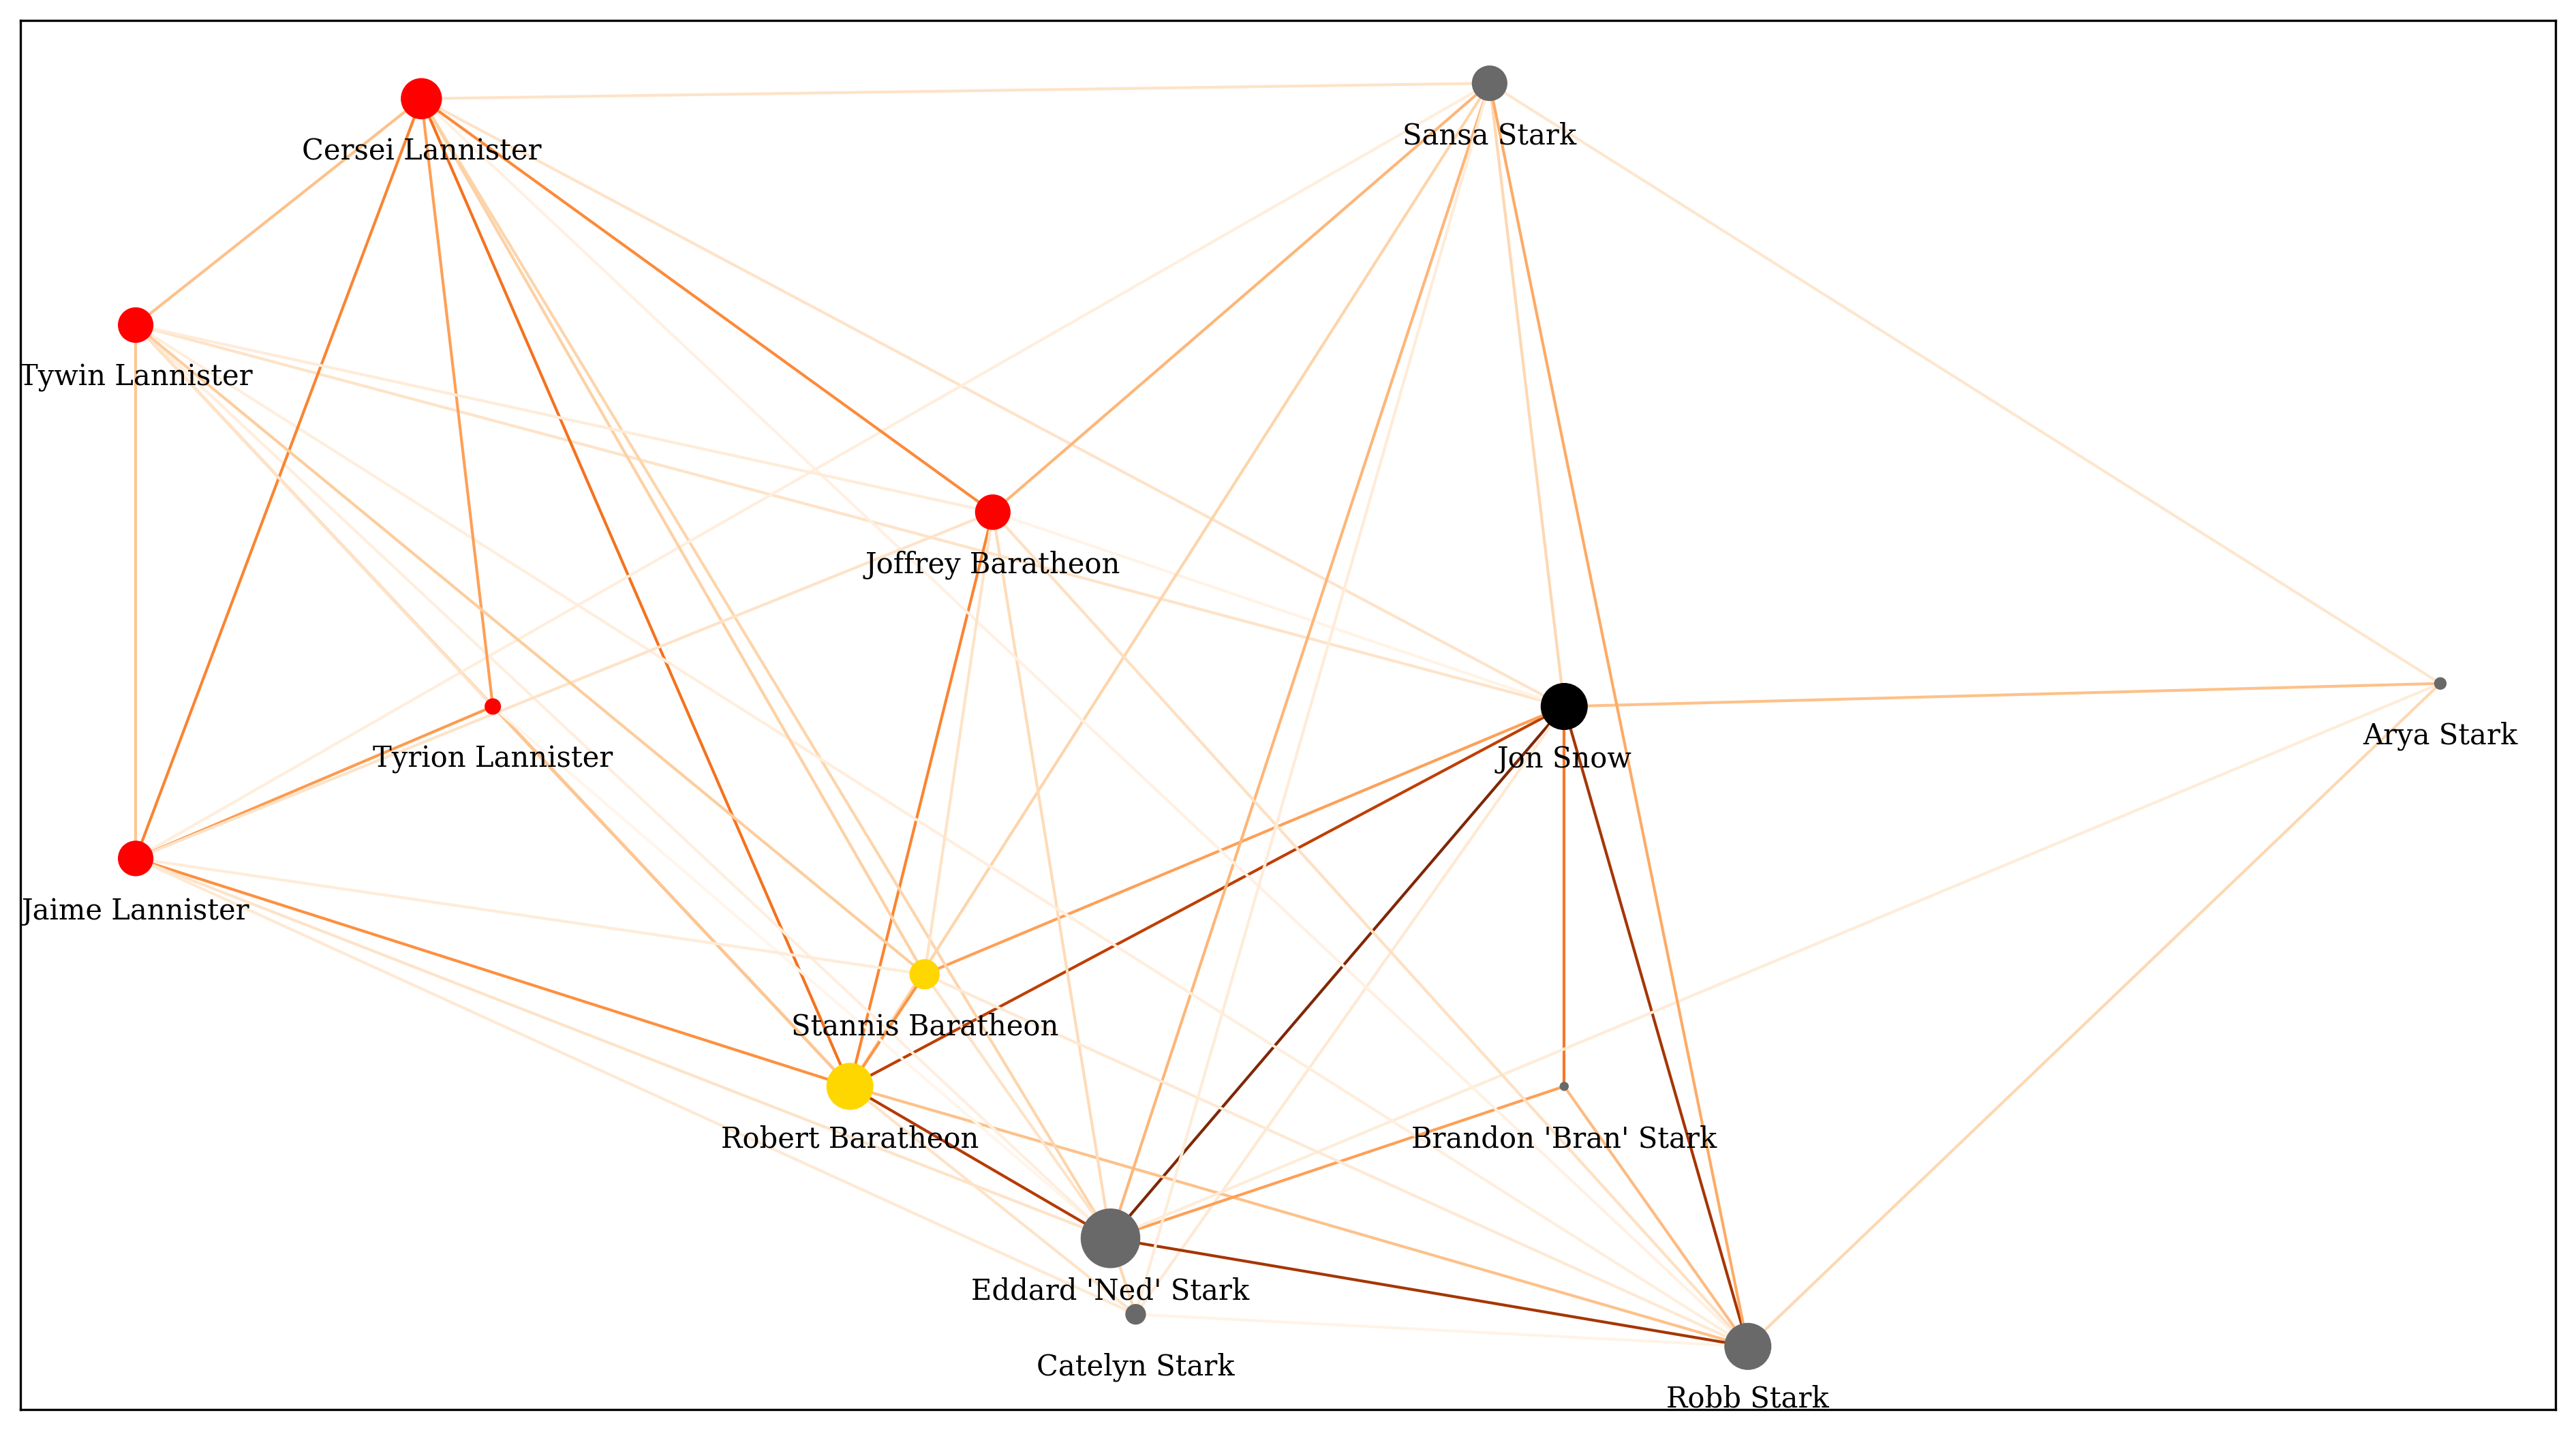

In [85]:
plot_graph(G_book, weight_cutoff=0.2)

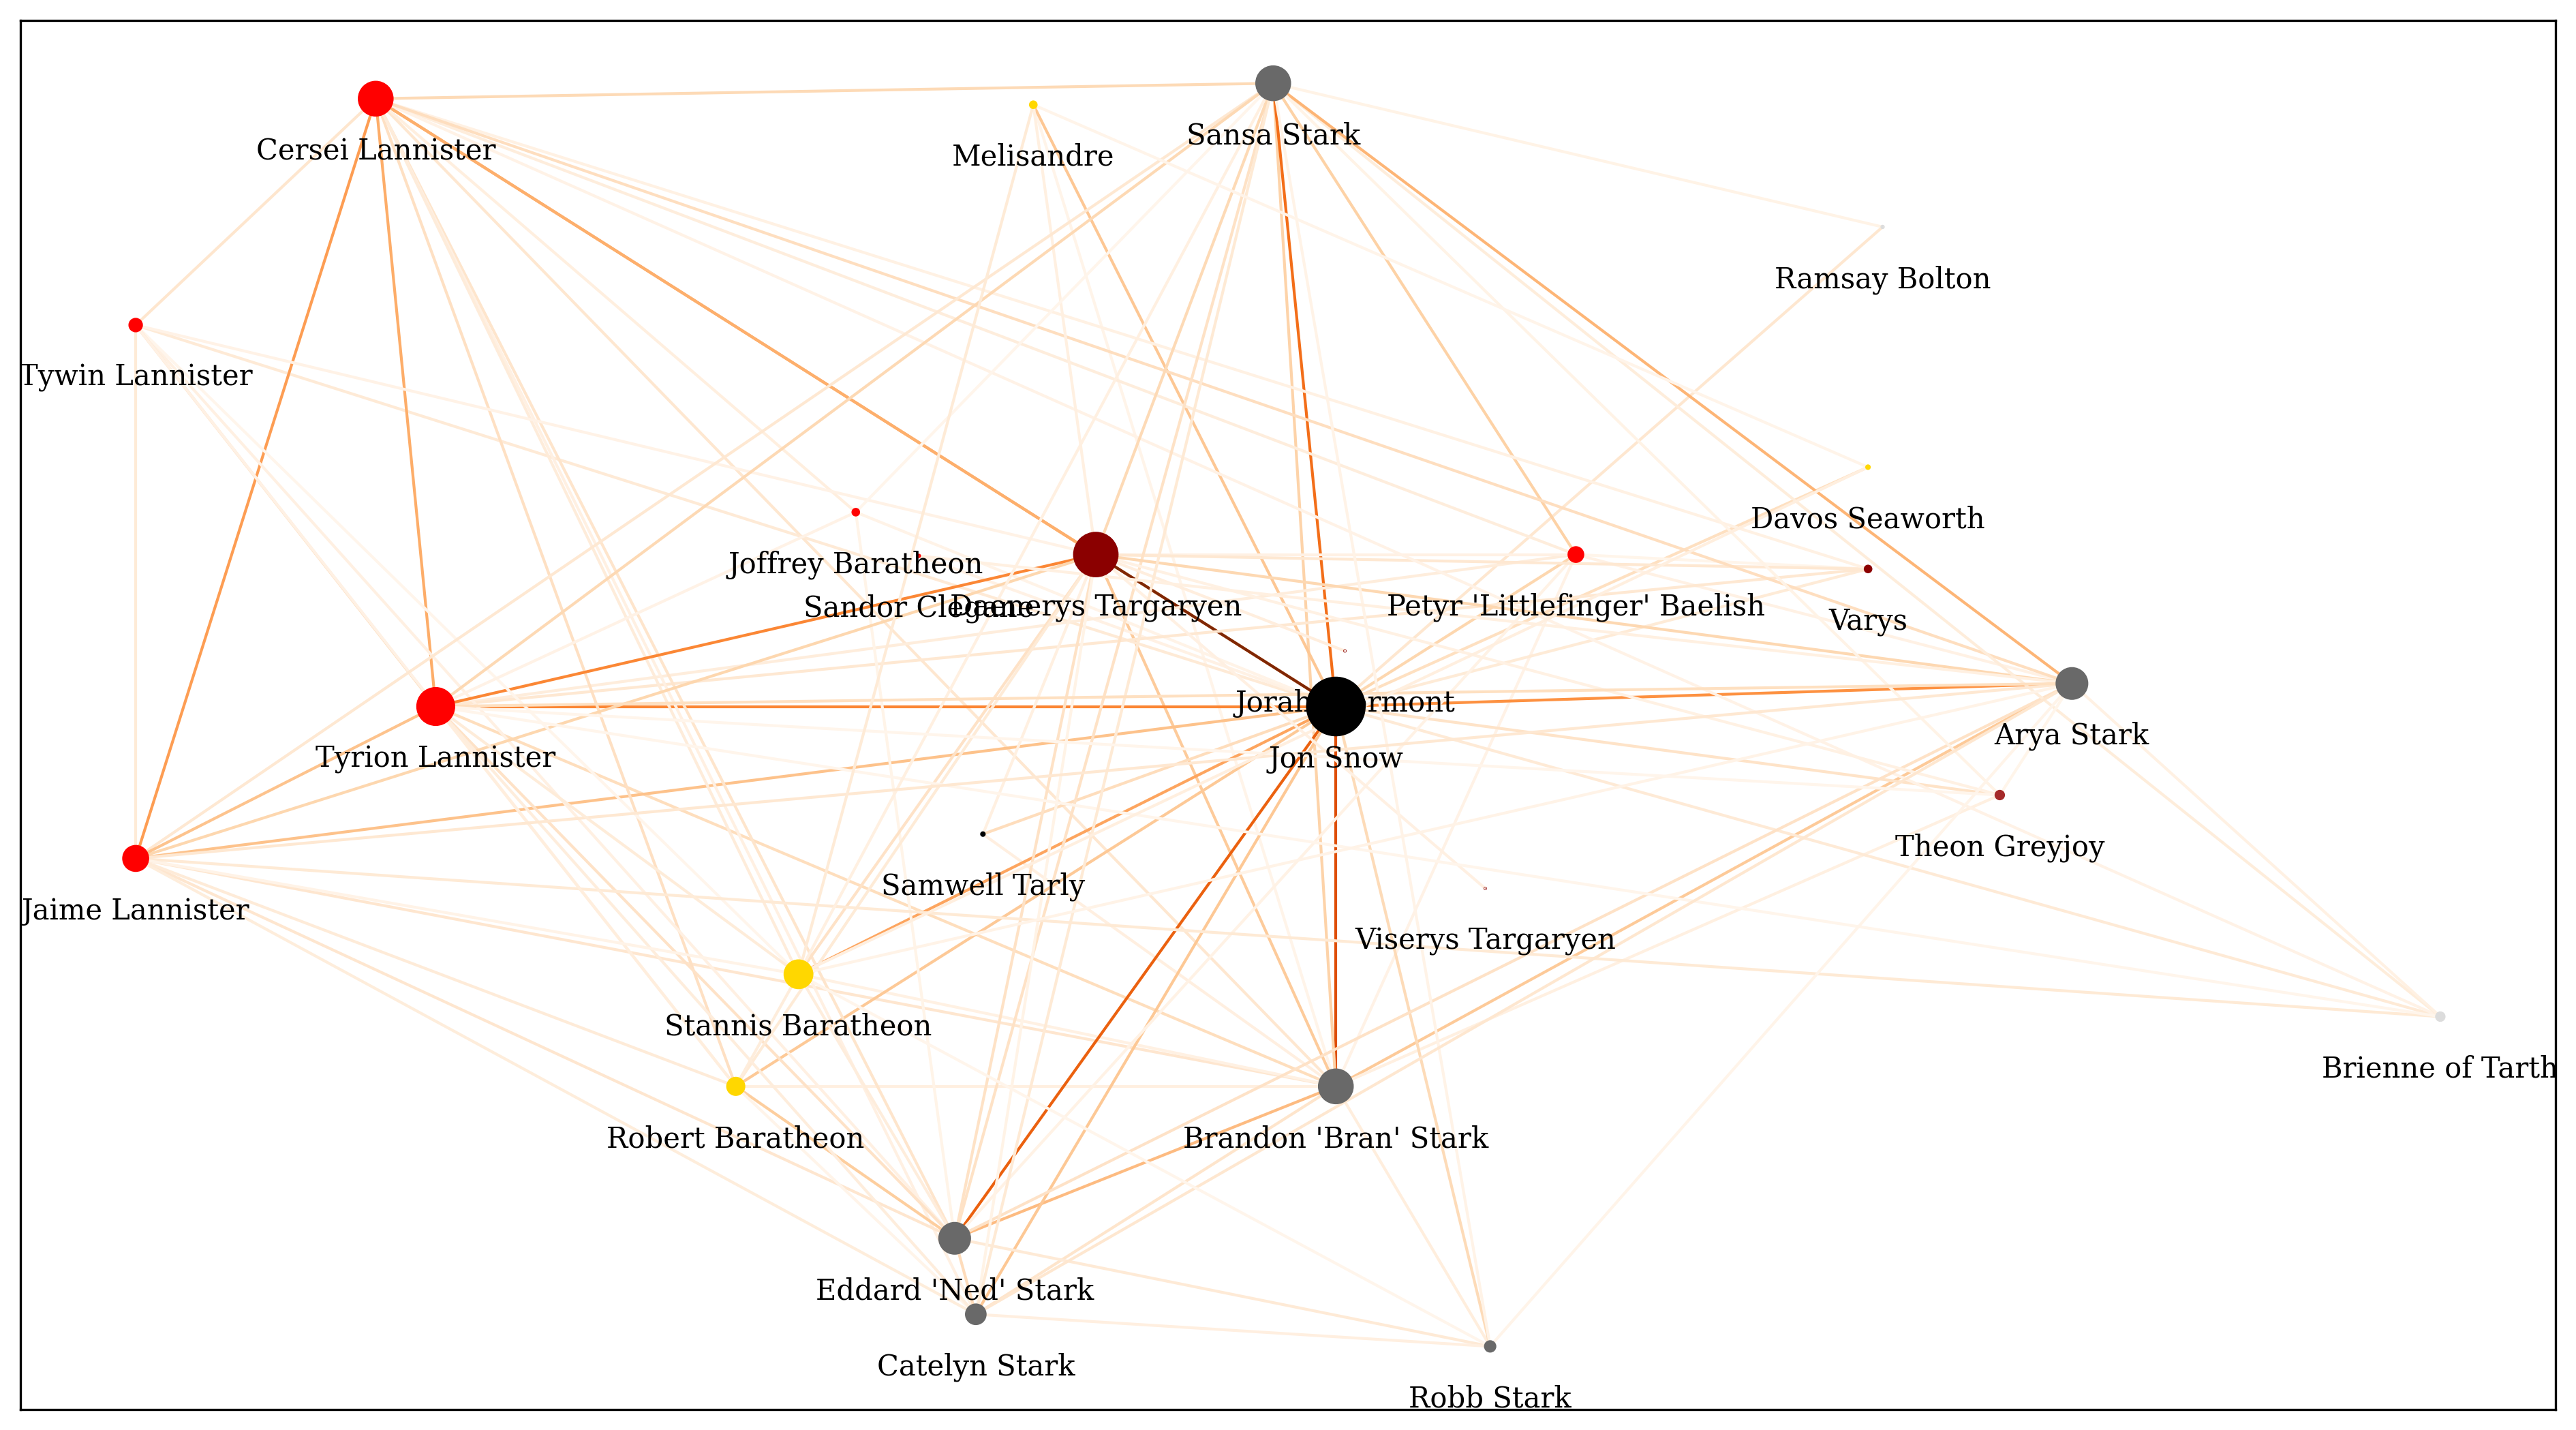

In [87]:
plot_graph(G_reddit, weight_cutoff=0.01)

Weight distribution for Books. Mean: 7.49, std.: 7.87
Weight distribution for Reddit. Mean: 0.67, std.: 0.79


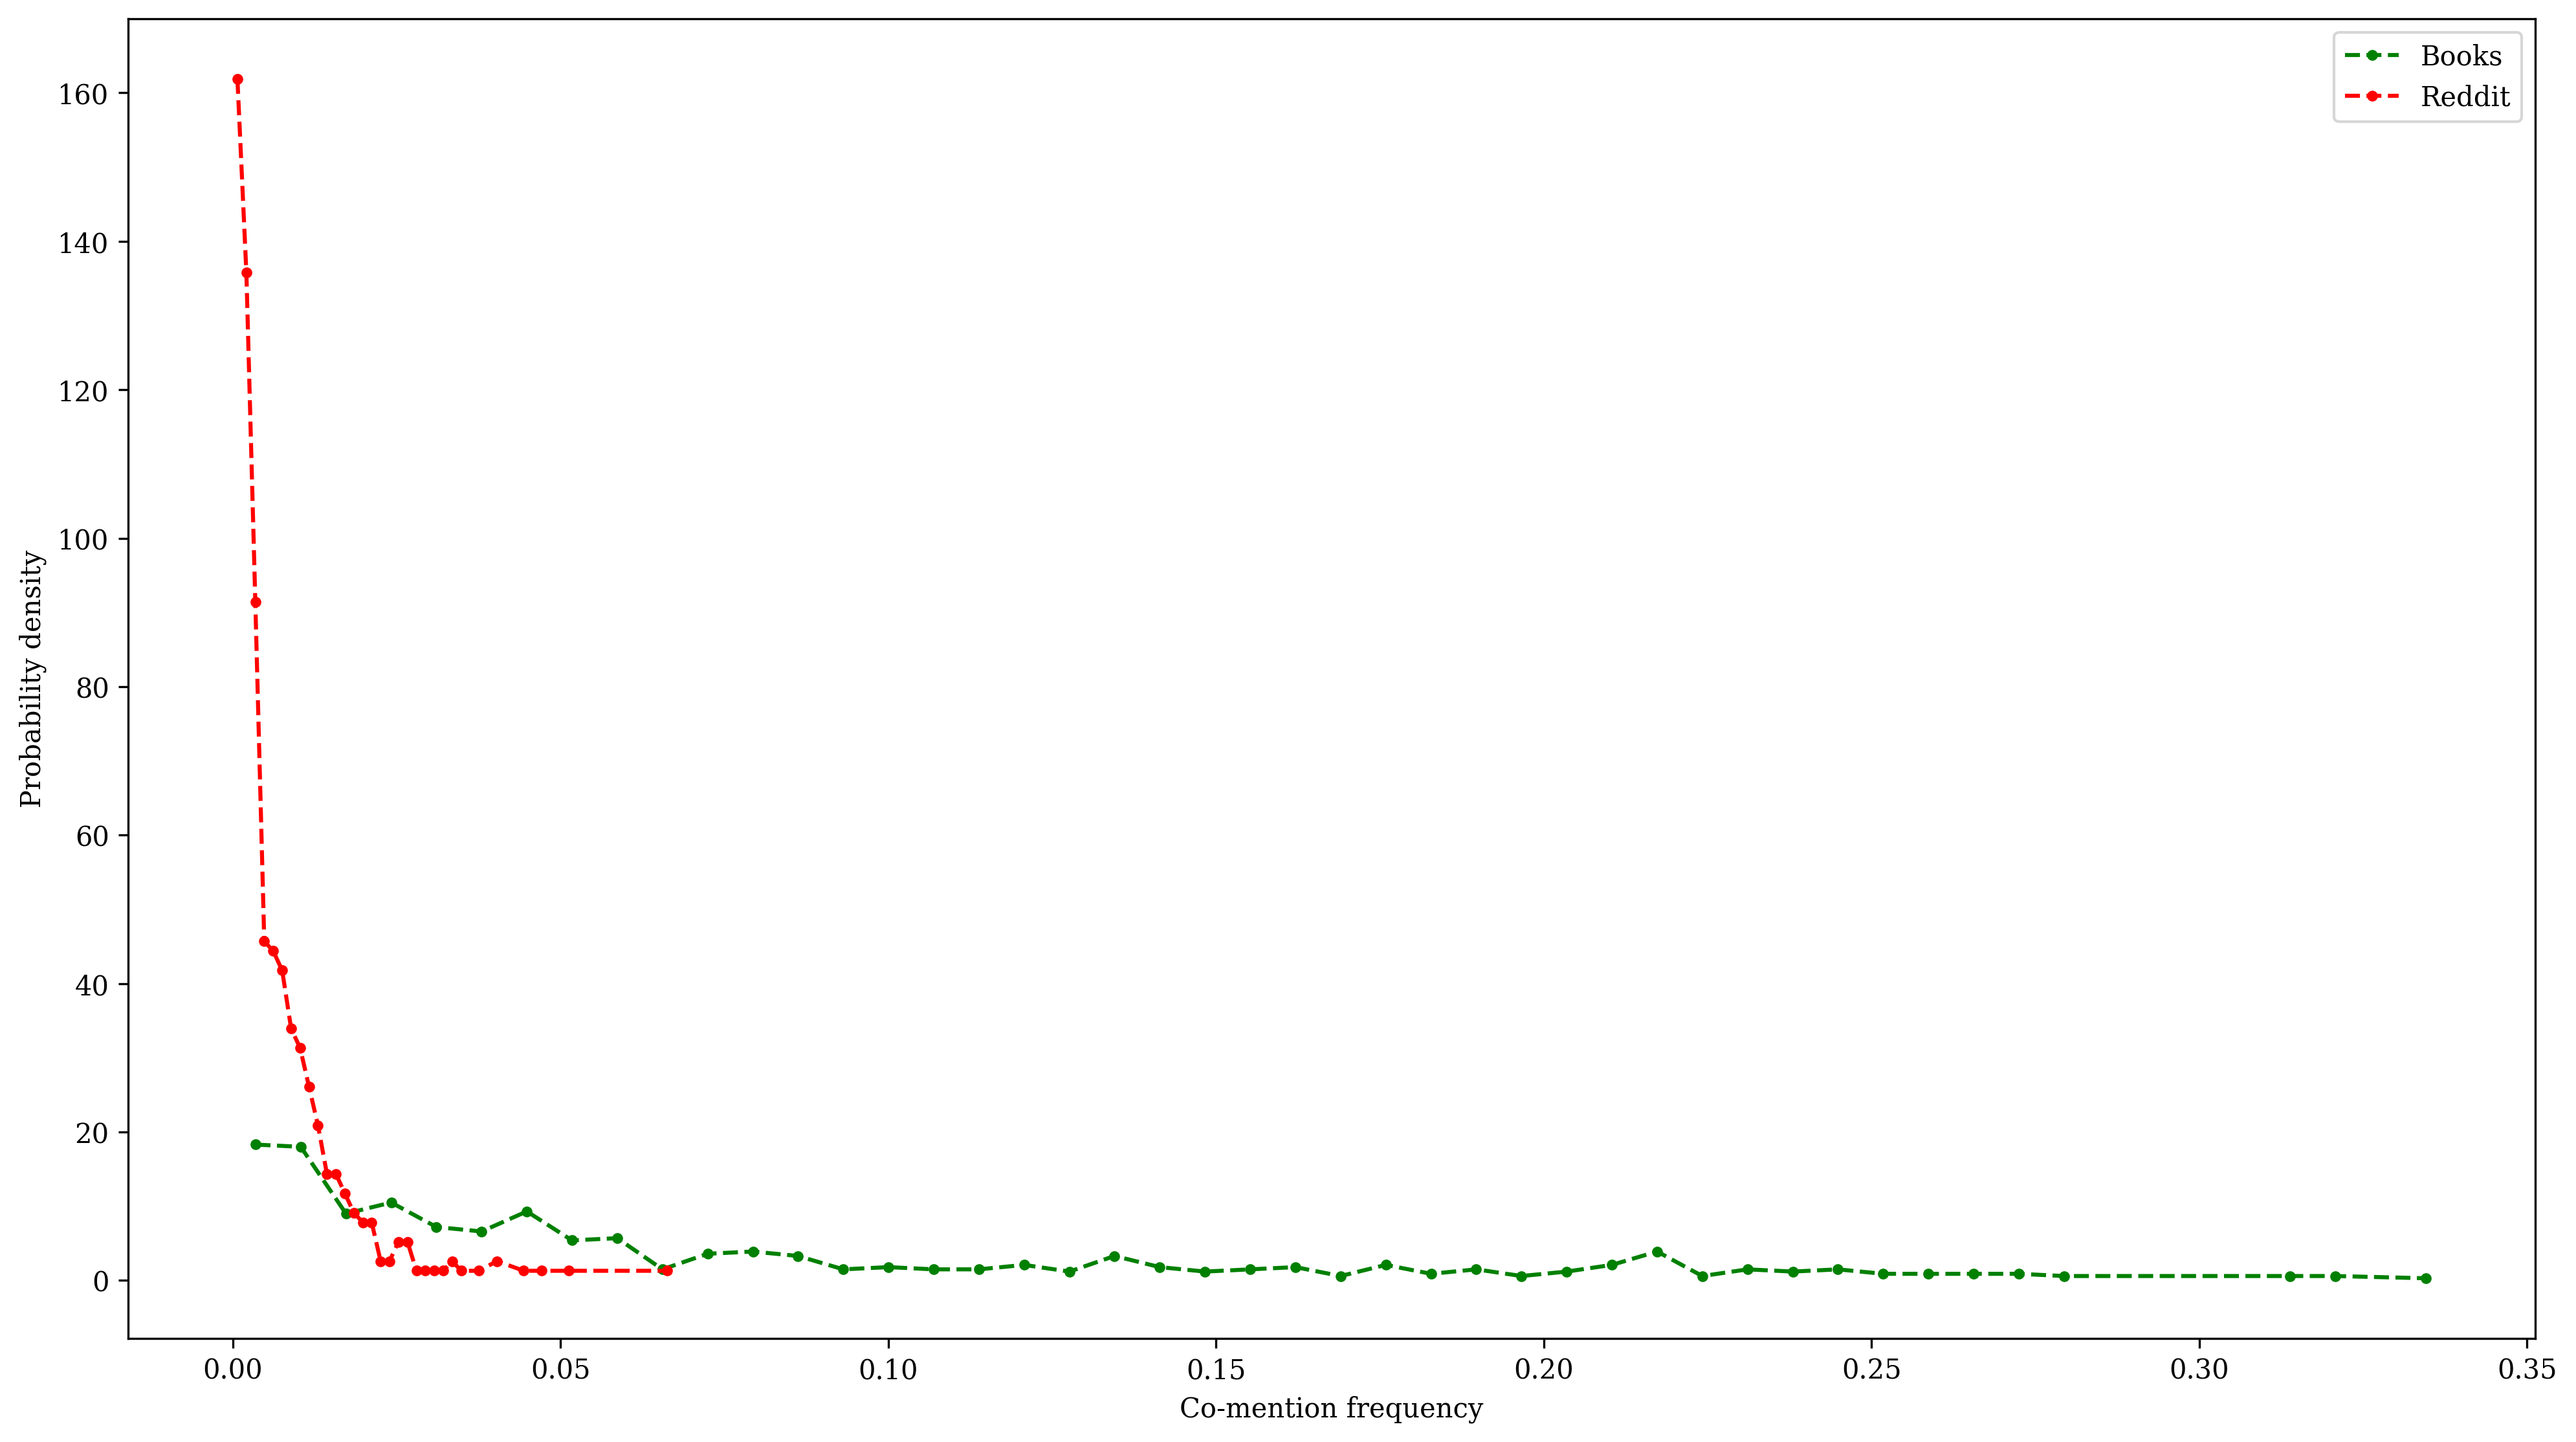

In [270]:
""" Weight distribution """
fig, ax = plt.subplots(figsize = (16, 9))

names = ("Books", "Reddit")
colours = "gr"

n_bins = 50

for i, G in enumerate((G_book, G_reddit)):
    weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    bins = np.linspace(0, weights.max(), n_bins)

    hist, edges = np.histogram(weights, bins=bins, density=True)

    x = (edges[1:] + edges[:-1])/2

    ax.plot(x[hist > 0], hist[hist > 0], marker='.', color=colours[i], ls="--", label=names[i])
    
    print(f"Weight distribution for {names[i]}. Mean: {weights.mean()*100:.2f}, std.: {weights.std()*100:.2f}")


ax.legend()
ax.set_xlabel("Co-mention frequency")
ax.set_ylabel("Probability density")

plt.show()

In [148]:
""" Shortest paths """
d_book = nx.average_shortest_path_length(G_book, weight="weight")
d_red = nx.average_shortest_path_length(G_reddit, weight="weight")
print(f"Book: {d_book:.4f}, Reddit: {d_red:.4f}")

Book: 0.0122, Reddit: 0.0011


In [152]:
c_book = nx.algorithms.average_clustering(G_book, weight="weight")
c_red = nx.algorithms.average_clustering(G_reddit, weight="weight")
print(f"Book: {c_book:.4f}, Reddit: {c_red:.4f}")

Book: 0.1600, Reddit: 0.0811


### 3.2 Graph communities

### 3.3 Understanding the text


#### Talk about how you've worked with text, including regular expressions, unicode, etc.

#### Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

#### How did you use the tools to understand your dataset?

## 4. What do we understand?

####    What went well?

####    What is still missing? What could be improved?, Why?
